# Clustering

Clustering algorithms are a subset of unsupervised machine learning techniques that group similar data points together based on certain characteristics or features. The main goal of clustering is to partition a dataset into groups, or clusters, where the data points within each cluster are more similar to each other than to those in other clusters.

There are various clustering algorithms, each with its own approach and characteristics. Some of the most common clustering algorithms include K-means, hierarchical clustering, DBSCAN (Density-Based Spatial Clustering of Applications with Noise), and Gaussian Mixture Models (GMM).

K-means is one of the simplest and most widely used clustering algorithms. It partitions the dataset into K clusters by iteratively assigning data points to the nearest cluster centroid and updating the centroids based on the mean of the data points assigned to each cluster.

Hierarchical clustering builds a tree-like hierarchy of clusters by either starting with individual data points as clusters and then merging them iteratively, or by starting with all data points as one cluster and then splitting them recursively.

DBSCAN identifies clusters based on the density of data points in the feature space. It groups together closely packed points and marks points in low-density regions as outliers.

Gaussian Mixture Models represent the distribution of data points as a mixture of multiple Gaussian distributions. It models each cluster as a Gaussian distribution and assigns data points probabilistically to each cluster.

Choosing the appropriate clustering algorithm depends on factors such as the structure of the data, the desired number of clusters, and the computational resources available. Evaluating clustering results often involves metrics such as silhouette score, Davies–Bouldin index, or visual inspection. Clustering finds applications in various fields including pattern recognition, image analysis, customer segmentation, and anomaly detection.

## Librays

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data

In [69]:
df = pd.read_csv("data\clients\marketing_campaign.csv", sep='\t')
print(df.columns)
df.head()

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [70]:
X = df[['Year_Birth', 'Income']]
X.head()

,Year_Birth,Income
0,1957,58138.0
1,1954,46344.0
2,1965,71613.0
3,1984,26646.0
4,1981,58293.0



## K-means


* K-means is an iterative procedure that
     * Starts by guessing the initial centroids, and then 
     * Refines this guess by 
         * Repeatedly assigning examples to their closest centroids, and then 
         * Recomputing the centroids based on the assignments.

* The inner-loop of the algorithm repeatedly carries out two steps: 
    1. Assigning each training example $x^{(i)}$ to its closest centroid, and
    2. Recomputing the mean of each centroid using the points assigned to it. 
    
    
* The $K$-means algorithm will always converge to some final set of means for the centroids. 

* However, the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

In [71]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): (K, n) centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """
    
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(X.shape[0]):
        distance = [] 
        for j in range(centroids.shape[0]):
            # Compute Euclidean distance
            norm_ij = np.linalg.norm(X[i] - centroids[j])
            distance.append(norm_ij)
        idx[i] = np.argmin(distance)
    
    return idx

For every centroid $\mu_k$, is seted

$$\mu_k = \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}$$ 

    where 
    * $C_k$ is the set of examples that are assigned to centroid $k$
    * $|C_k|$ is the number of examples in the set $C_k$


If two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k=2$,
then you should update $\mu_2 = \frac{1}{2}(x^{(3)}+x^{(5)})$.

In [72]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    m, n = X.shape
    centroids = np.zeros((K, n))
    
    for k in range(K):
        X_k = X[idx == k]
        c_k = np.mean(X_k, axis=0)
        
        # Alternative:
        # X_k= []
        # for i, id in enumerate(idx):
        #     if id == k:
        #         X_k2.append(X[i])

        # c_k = sum(X_k2) / len(X_k2)
        
        centroids[k] = c_k
    
    return centroids

In [73]:
def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be 
    used in K-Means on the dataset X
    
    Args:
        X (ndarray): Data points 
        K (int):     number of centroids/clusters
    
    Returns:
        centroids (ndarray): Initialized centroids
    """
    
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])
    
    # Take the first K examples as centroids
    centroids = X[randidx[:K]]
    
    return centroids

## Run kmeans

In [74]:
def plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i):
    """
    Plots the progress of the K-Means algorithm
    """
    plt.scatter(X[:, 0], X[:, 1], c=idx, cmap='viridis', marker='.')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=300, c='r', edgecolors='k', label='Centroids')
    plt.scatter(previous_centroids[:, 0], previous_centroids[:, 1], marker='x', s=200, c='k', label='Previous Centroids')
    plt.title(f"Iteration {i+1}")
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)

In [75]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Check if X is a DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values  # Transform DataFrame to NumPy array
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))
    
    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i+1, max_iters))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids.copy()
        
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    
    plt.show() 
    return centroids, idx

## Image compression aplication

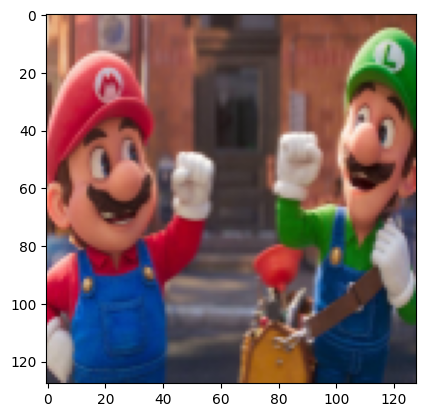

In [107]:
original_img = plt.imread('data\\figure.png')
plt.imshow(original_img)

In [108]:
print("Shape of original_img is:", original_img.shape)

Shape of original_img is: (128, 128, 4)


The fourth channel is transparence, so we will remove that.

In [112]:
rgb_img = original_img[:, :, :3]

In [116]:
# Divide by 255 so that all values are in the range 0 - 1 (not needed for PNG files)
# rgb_img = rgb_img / 255

# Reshape the image into an m x 3 matrix where m = number of pixels
# (in this case m = 128 x 128 = 16384)
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X_img that we will use K-Means on.

X_img = np.reshape(rgb_img, (rgb_img.shape[0] * rgb_img.shape[1], 3))

In [117]:
# Run your K-Means algorithm on this data
# You should try different values of K and max_iters here
K = 16
max_iters = 10

# Using the function you have implemented above. 
initial_centroids = kMeans_init_centroids(X_img, K)

# Run K-Means - this can take a couple of minutes depending on K and max_iters
centroids, idx = run_kMeans(X_img, initial_centroids, max_iters)

K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


<Figure size 800x600 with 0 Axes>

In [118]:
print("Shape of idx:", idx.shape)
print("Closest centroid for the first five elements:", idx[:5])

Shape of idx: (16384,)
Closest centroid for the first five elements: [0 4 4 0 4]


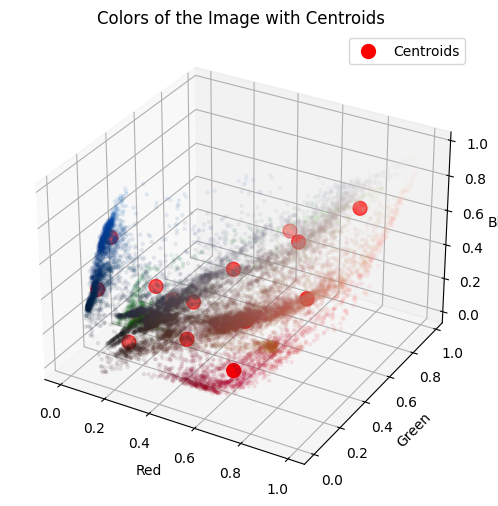

In [134]:
def plot_kMeans_RGB(X_img, centroids, idx, K):
    """
    Plot the colors of the image and mark the centroids
    """
    # Flatten the image to extract RGB values
    X_flat = X_img.reshape(-1, 3)
    R = X_flat[:, 0]
    G = X_flat[:, 1]
    B = X_flat[:, 2]

    # Plot all colors in the original image
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(R, G, B, c=X_flat, marker='.', alpha=0.08)

    # Mark centroids with red markers
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='r', marker='o', s=100, label='Centroids')
    
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('Colors of the Image with Centroids')
    plt.legend()
    plt.show()

plot_kMeans_RGB(X_img, centroids, idx, K)

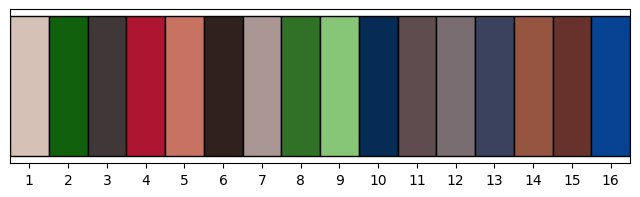

In [159]:
def show_centroid_colors(centroids):
    """
    Visualize the 16 centroid colors selected
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 2))
    
    # Plot the centroid colors as a horizontal bar
    for i, color in enumerate(centroids):
        ax.barh(0, 1, color=color, left=i, edgecolor='black')
    
    # Set axis limits and hide Y-axis
    ax.set_xlim(0, len(centroids))
    ax.yaxis.set_visible(False)
    
    # Set X-axis ticks and labels
    ax.set_xticks(np.arange(0.5, len(centroids), 1))
    ax.set_xticklabels(np.arange(1, len(centroids) + 1))
    
    # Show the plot
    plt.show()

# Visualize the centroid colors
show_centroid_colors(centroids)


### Compress the image

After finding the top $K=16$ colors to represent the image, you can now
assign each pixel position to its closest centroid using the
`find_closest_centroids` function. 
* This allows you to represent the original image using the centroid assignments of each pixel. 
* Notice that you have significantly reduced the number of bits that are required to describe the image. 
    * The original image required 24 bits (i.e. 8 bits x 3 channels in RGB encoding) for each one of the $128\times128$ pixel locations, resulting in total size of $128 \times 128 \times 24 = 393,216$ bits. 
    * The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. 
    * The final number of bits used is therefore $16 \times 24 + 128 \times 128 \times 4 = 65,920$ bits, which corresponds to compressing the original image by about a factor of 6.

In [162]:
# Find the closest centroid of each pixel
idx = find_closest_centroids(X_img, centroids)

# Replace each pixel with the color of the closest centroid
X_recovered = centroids[idx, :] 

# Reshape image into proper dimensions
X_recovered = np.reshape(X_recovered, rgb_img.shape) 

Finally, let's see the effects of the compression by reconstructing the image based only on the centroid assignments. 
* Specifically, we replaced each pixel with the value of the centroid assigned to it. 
* Even though the resulting image retains most of the characteristics of the original, you will also see some compression artifacts because of the fewer colors used.

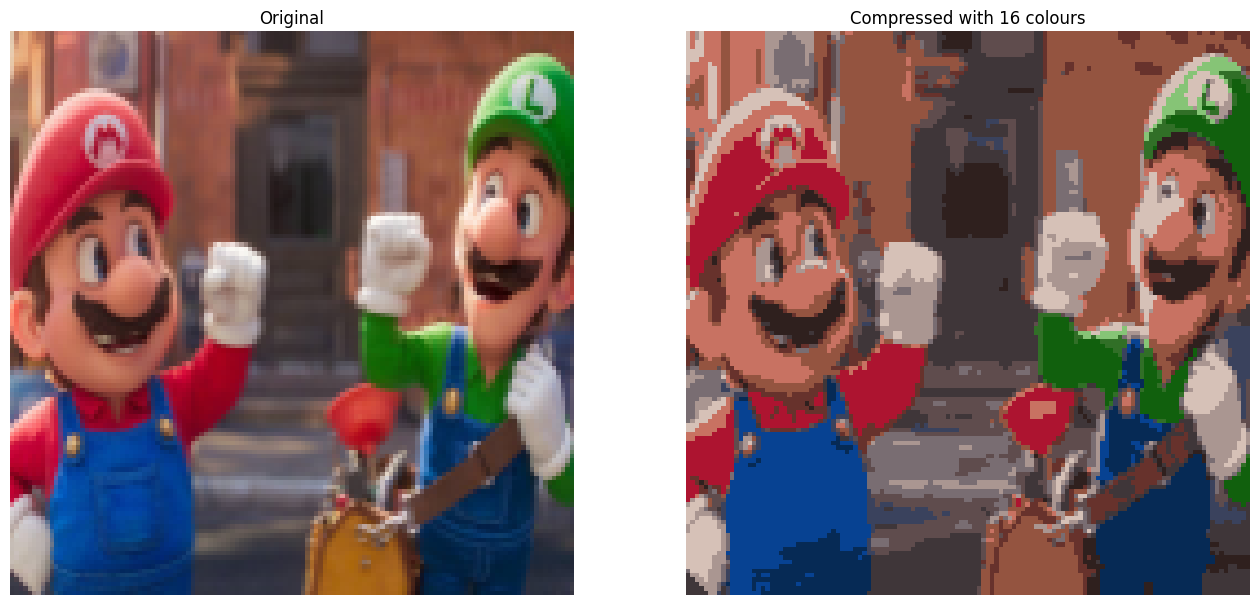

In [165]:
# Display original image
fig, ax = plt.subplots(1,2, figsize=(16,16))
plt.axis('off')

ax[0].imshow(rgb_img)
ax[0].set_title('Original')
ax[0].set_axis_off()


# Display compressed image
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed with %d colours'%K)
ax[1].set_axis_off()